# Loss of reproducibility of results when kernel is restart. 

This same behaviour occurs if I run two separate scripts and compare their results. 

- I am using Python3

After thinking about this for a while I came across the fact that floating point arithmetic gives different results on different machines. This is either due to a different order of operations being used (a*(b+c) != ab + ac) or due to a more precise type being used internally and rounding giving a different result. That said, I saw no situation exactly like this one and am not sure if floating point magic is to blame. I am hoping the reader can advise.

Description of behaviour:

I load in the sqg model object and set some initial conditions. I then run the model. I save the field at the first timestep. 
I repeat the above for a new instance of sqg model with the exact same initialisation. 
If I do not restart the kernel in-between running the first and second model (I will call this a "no restart run") then the results agree with each other exactly.
If I do restart the kernel after running the first model (I will call this a "restart run"), the fields at the first timestep disagree with error on the order of 10^-16.

What I have tried:

- Deleting the sqg model object between running the models during a no restart run, I saw no difference in the fields.
- I set a seed in my own version of pyqg, but this did not have any effect.
- I read through pyqg looking for places where random noise could be added, I was not able to find this.
- I was advised it could be to do with file compression, but npy is lossless and from my own playing reproduces matrices perfectly.
- Updating my conda environment had no effect.

Something I noticed is I get the second "model initialised" message more quickly during a no restart run (with the imports loaded separately). 

To reproduce the behaviour run the cells below in order: 


In [1]:
# Create the sqg model object, pyqg must be in your environment, I also have pyfft.
# If you have miniconda you can get it using conda install -c conda-forge pyqg 

import numpy as np
from pyqg import sqg_model

model1 = sqg_model.SQGModel(L=2.*np.pi,nx=512, tmax = 0.01,
           Nb = 1., dt = 0.005,
                     taveint=0.005, twrite=400, ntd=1 ,tavestart=0)

# Set the initial conditions

x = np.linspace(model1.dx/2,2*np.pi,model1.nx) - np.pi
y = np.linspace(model1.dy/2,2*np.pi,model1.ny) - np.pi
x,y = np.meshgrid(x,y)
qi = -np.exp(-(x**2 + (4.0*y)**2)/(model1.L/6.0)**2)

model1.set_q(qi[np.newaxis,:,:])

model1.run()

field1 = model1.q.squeeze() + 0 * model1.y

np.save('field1', field1)


INFO:  Logger initialized


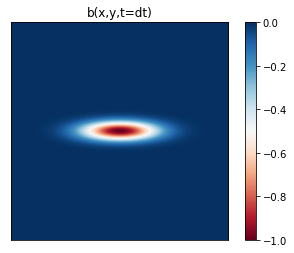

In [3]:
# See what "field" is 

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'RdBu'
plt.clf()
p1 = plt.imshow(field1)
plt.title('b(x,y,t=dt)')
plt.colorbar()
plt.clim([-1, 0])
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# Create the second sqg model object

import numpy as np
from pyqg import sqg_model

model2 = sqg_model.SQGModel(L=2.*np.pi,nx=512, tmax = 0.01,
           Nb = 1., dt = 0.005,
                     taveint=0.005, twrite=400, ntd=1 ,tavestart=0)

# Set the initial conditions

x = np.linspace(model2.dx/2,2*np.pi,model2.nx) - np.pi
y = np.linspace(model2.dy/2,2*np.pi,model2.ny) - np.pi
x,y = np.meshgrid(x,y)
qi = -np.exp(-(x**2 + (4.0*y)**2)/(model2.L/6.0)**2)

model2.set_q(qi[np.newaxis,:,:])

model2.run()

field2 = model2.q.squeeze() + 0 * model2.y

np.save('field2', field2)


INFO:  Logger initialized


In [5]:
# Compare the fields after 1 timestep

error = field1 - field2

np.all(error == 0) #the error should be 0 so we expect a True

True

In [6]:
# Does it make any difference if we load the files in instead?

field1load = np.load("field1.npy")
field2load = np.load("field2.npy")

errorload = field1load - field2load

np.all(errorload == 0) #no it shouldn't, we expect another true

True

# Now restart the kernel

(click the little black circular arrow at the top of the window)

In [1]:
# Create the second sqg model object again (this is the exact same code as the first time)

import numpy as np
from pyqg import sqg_model

model2 = sqg_model.SQGModel(L=2.*np.pi,nx=512, tmax = 0.01,
           Nb = 1., dt = 0.005,
                     taveint=0.005, twrite=400, ntd=1 ,tavestart=0)

# Set the initial conditions

x = np.linspace(model2.dx/2,2*np.pi,model2.nx) - np.pi
y = np.linspace(model2.dy/2,2*np.pi,model2.ny) - np.pi
x,y = np.meshgrid(x,y)
qi = -np.exp(-(x**2 + (4.0*y)**2)/(model2.L/6.0)**2)

model2.set_q(qi[np.newaxis,:,:])

model2.run()

field2 = model2.q.squeeze() + 0 * model2.y

np.save('field2', field2)

INFO:  Logger initialized


In [2]:
# Now is there a difference?

field1load = np.load("field1.npy")
field2load = np.load("field2.npy")

error = field1load - field2load

np.all(error == 0) #yes, we get False, surprisingly there is now an error

False

<IPython.core.display.Javascript object>


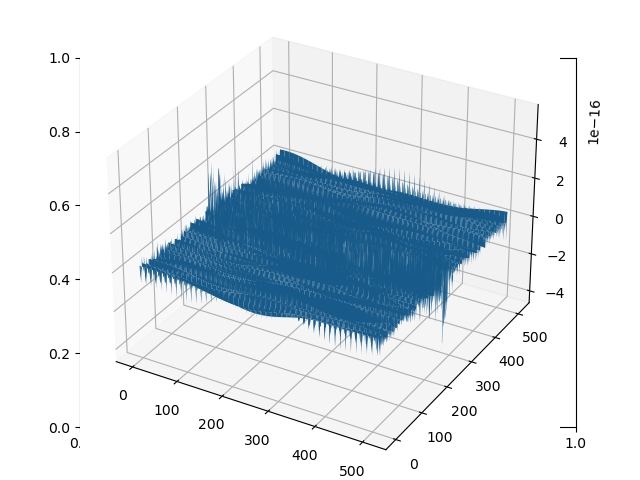

/tmp/ipykernel_13800/2869322508.py:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [3]:
# What does the error look like?

%matplotlib notebook 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(len(error[0]))
Y = np.arange(len(error[0]))
X,Y = np.meshgrid(X,Y)

fig, ax = plt.subplots()
ax = Axes3D(fig)
ax.plot_surface(X,Y,error)

As you can see, the error is on the scale of machine error. It seems to be greater where the buoyancy is greater which is probably just because of catastrophic cancellation ie if you store two numbers in double precision there will generally be greater absolute error between larger numbers than smaller numbers. But why is there error in the first place, why is the code being executed slightly differently after the kernel has restarted?